In [ ]:
!pip install mediapipe

     |████████████████████████████████| 47.4MB 126kB/s 


In [ ]:
save_path = "/content/content/checkpoints"
PATH = "/content/content/colors1_croped_resized"

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

# Copyright (c) Liuhao Ge. All Rights Reserved.
"""
Basic evaluation script for PyTorch
"""
import scipy.io as sio
import time

import argparse
import os.path as osp
import torch
from tqdm.notebook import tqdm as tqdm


from IPython.display import HTML, Audio, display, Javascript, Image
from base64 import b64decode, b64encode
import numpy as np
import html
import time
import io
import PIL
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from torch import nn as nn
import mediapipe as mp

# Utils

In [ ]:
def get_labels(path="/content/colors_data.txt"):

  """ Returns a dictionary with (x,y) pairs according to name"""

  import ast

  f = open(path, "r")
  a = f.read()
  f.close()

  index_1 = a.find("}")
  joystick_coords = a[0:index_1 + 1]
  joystick_coords = ast.literal_eval(joystick_coords)

  for key in joystick_coords.keys():
    
    a = joystick_coords[key]
    a = (a.split(",")[0][1:], a.split(",")[1][:-1])
    joystick_coords[key] = (float(a[0]), float(a[1]))
    
  return joystick_coords

In [ ]:
class handDetector():
    def __init__(self, mode=True, maxHands=2, detectionCon=0.5, trackCon=0.5):
        self.mode = mode
        self.maxHands = maxHands
        self.detectionCon = detectionCon
        self.trackCon = trackCon

        self.mpHands = mp.solutions.hands
        self.hands = self.mpHands.Hands(self.mode, self.maxHands,
                                        self.detectionCon, self.trackCon)
        self.mpDraw = mp.solutions.drawing_utils

    def find_hands(self, img, draw=True):
        imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        self.results = self.hands.process(imgRGB)

        if self.results.multi_hand_landmarks:
            for handLms in self.results.multi_hand_landmarks:
                if draw:
                    self.mpDraw.draw_landmarks(img, handLms, self.mpHands.HAND_CONNECTIONS)
        return img
    

    def get_num(self, num):
        temp = num.split(".")
        num = temp[0] + "." + temp[1][:3]
        return num

    def find_position(self, img, hand_num=0, draw=True):
        lmList = []
        if self.results.multi_hand_landmarks:
            my_hand = self.results.multi_hand_landmarks[hand_num]

            for id, lm in enumerate(my_hand.landmark):
                if id == 5 or id == 9 or id == 13 or id == 17:
                    x = self.get_num(str(lm.x))
                    y = self.get_num(str(lm.y))
                    z = self.get_num(str(lm.z))

                    print(f'Joint: {id}\nX: {x}\nY: {y}\nZ: {z}\n')

                h, w, c = img.shape
                cx, cy = int(lm.x * w), int(lm.y * h)
                # print(id, cx, cy)
                lmList.append([id, cx, cy])
                if draw:
                    cv2.circle(img, (cx, cy), 5, (255, 0, 255), cv2.FILLED)

        return lmList
    
    def find_pos(self, img, hand_num=0, draw=False):
        global count
        global prev_angels
        global prev_xz_angels
        
        lmList = []
        angle = 0
        xz_angle = 0
        
        if self.results.multi_hand_landmarks:
            my_hand = self.results.multi_hand_landmarks[hand_num]

            id_5 = [0, 0, 0]
            id_9 = [0, 0, 0]
            id_13 = [0, 0, 0]
            id_17 = [0, 0, 0]
            
            for id, lm in enumerate(my_hand.landmark):
                if id == 5:
                    id_5[0] = lm.x
                    id_5[1] = lm.y
                    id_5[2] = lm.z
                
                if id == 9:
                    id_9[0] = lm.x
                    id_9[1] = lm.y
                    id_9[2] = lm.z

                if id == 13:
                    id_13[0] = lm.x
                    id_13[1] = lm.y
                    id_13[2] = lm.z

                if id == 17:
                    id_17[0] = lm.x
                    id_17[1] = lm.y
                    id_17[2] = lm.z

                h, w, c = img.shape
                cx, cy = int(lm.x * w), int(lm.y * h)
                # print(id, cx, cy)
                lmList.append([id, cx, cy])
                if draw:
                    cv2.circle(img, (cx, cy), 5, (255, 0, 255), cv2.FILLED)

            # ---1----

            difference = np.array(id_5) - np.array(id_17)
            angle = np.arctan2(difference[0],difference[2]) #+ np.pi
            
            # ---

            zplane = np.array([0,1,0]).astype(np.float)
            vec_normed = np.linalg.norm(difference)
            zplane_normed = np.linalg.norm(zplane)

            result = (difference*zplane)/(vec_normed*zplane_normed)
            xz_angle = np.arcsin(np.sum(result))
            
            xz_angle = (1-np.abs((xz_angle/ np.pi) * (2)))

            if draw:
              x = int(np.cos(avg_angles)* avg_prev_xz_angels*300) + 300
              y = int(np.sin(avg_angles)* avg_prev_xz_angels*300) + 300
              
              cv2.circle(img, (x,y), 5,(255, 0, 0), cv2.FILLED)
              cv2.line(img, (300,300),(x,y),(255,255,0),2)
                          
              cv2.putText(img, f'xz_angels {str(avg_prev_xz_angels)}', (2, 30), cv2.FONT_HERSHEY_PLAIN, 1, (0, 0, 255), 2)
              cv2.putText(img, f'angles {avg_angles}', (2, 50), cv2.FONT_HERSHEY_PLAIN, 1, (0, 0, 255), 2)
            
            
        else:
            return None, None
            
        return angle, xz_angle

In [ ]:
# import torchvision.models as models

class PoseToVecModel(torch.nn.Module):
    def __init__(self, inputSize=2, outputSize=2, depth=0, width=8):
        super(PoseToVecModel, self).__init__()
        # self.linear = torch.nn.Linear(inputSize, outputSize)

        mlist = [nn.Linear(inputSize, width)]
        rlist = [torch.nn.PReLU()]
        for i in range(depth):
          mlist.append(nn.Linear(width, width))
          rlist.append(torch.nn.PReLU())

        self.last = nn.Linear(width, outputSize)

        self.linear = torch.nn.ModuleList(mlist)
        self.rels = torch.nn.ModuleList(rlist)

    def forward(self, x):
      for i in range(len(self.linear)):
        x = self.linear[i](x)
        x = self.rels[i](x)

      x = self.last(x)

      return x

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.optimizer import Optimizer, required
import math

class adamp(Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8,
                 weight_decay=0, delta=0.1, wd_ratio=0.1, nesterov=False):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay,
                        delta=delta, wd_ratio=wd_ratio, nesterov=nesterov)
        super(adamp, self).__init__(params, defaults)

    def _channel_view(self, x):
        return x.reshape(x.size(0), -1)

    def _layer_view(self, x):
        return x.reshape(1, -1)

    def _cosine_similarity(self, x, y, eps, view_func):
        x = view_func(x)
        y = view_func(y)

        return F.cosine_similarity(x, y, dim=1, eps=eps).abs_()

    def _projection(self, p, grad, perturb, delta, wd_ratio, eps):
        wd = 1
        expand_size = [-1] + [1] * (len(p.shape) - 1)
        for view_func in [self._channel_view, self._layer_view]:

            cosine_sim = self._cosine_similarity(grad, p.data, eps, view_func)

            if cosine_sim.max() < delta / math.sqrt(view_func(p.data).size(1)):
                p_n = p.data / view_func(p.data).norm(dim=1).view(expand_size).add_(eps)
                perturb -= p_n * view_func(p_n * perturb).sum(dim=1).view(expand_size)
                wd = wd_ratio

                return perturb, wd

        return perturb, wd

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue

                grad = p.grad.data
                beta1, beta2 = group['betas']
                nesterov = group['nesterov']

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p.data)
                    state['exp_avg_sq'] = torch.zeros_like(p.data)

                # Adam
                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']

                state['step'] += 1
                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']

                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                denom = (exp_avg_sq.sqrt() / math.sqrt(bias_correction2)).add_(group['eps'])
                step_size = group['lr'] / bias_correction1

                if nesterov:
                    perturb = (beta1 * exp_avg + (1 - beta1) * grad) / denom
                else:
                    perturb = exp_avg / denom

                # Projection
                wd_ratio = 1
                if len(p.shape) > 1:
                    perturb, wd_ratio = self._projection(p, grad, perturb, group['delta'], group['wd_ratio'], group['eps'])

                # Weight decay
                if group['weight_decay'] > 0:
                    p.data.mul_(1 - group['lr'] * group['weight_decay'] * wd_ratio)

                # Step
                p.data.add_(perturb, alpha=-step_size)

        return loss

In [ ]:
"""Exponential moving average for PyTorch. Adapted from
https://www.zijianhu.com/post/pytorch/ema/.
"""

from copy import deepcopy

import torch
from torch import nn


class EMA(nn.Module):
    def __init__(self, model, decay):
        super().__init__()
        self.model = model
        self.decay = decay
        self.register_buffer('accum', torch.tensor(1.))
        self._biased = deepcopy(self.model)
        self.average = deepcopy(self.model)
        for param in self._biased.parameters():
            param.detach_().zero_()
        for param in self.average.parameters():
            param.detach_().zero_()
        self.update()

    @torch.no_grad()
    def update(self):
        if not self.training:
            raise RuntimeError('Update should only be called during training')

        self.accum *= self.decay

        model_params = dict(self.model.named_parameters())
        biased_params = dict(self._biased.named_parameters())
        average_params = dict(self.average.named_parameters())
        assert model_params.keys() == biased_params.keys() == average_params.keys()

        for name, param in model_params.items():
            biased_params[name].mul_(self.decay)
            biased_params[name].add_((1 - self.decay) * param)
            average_params[name].copy_(biased_params[name])
            average_params[name].div_(1 - self.accum)

        model_buffers = dict(self.model.named_buffers())
        biased_buffers = dict(self._biased.named_buffers())
        average_buffers = dict(self.average.named_buffers())
        assert model_buffers.keys() == biased_buffers.keys() == average_buffers.keys()

        for name, buffer in model_buffers.items():
            biased_buffers[name].copy_(buffer)
            average_buffers[name].copy_(buffer)

    def forward(self, *args, **kwargs):
        if self.training:
            return self.model(*args, **kwargs)
        return self.average(*args, **kwargs)

# Model

In [ ]:
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

class handDataset(Dataset):
  def __init__(self, x_train, y_train, transforms=None, preprocessing=None, y_angle=True):

    self.detector = handDetector()

    self.x_train = []

    for path in tqdm(x_train):
      img = cv2.imread(path)
      self.detector.find_hands(img, draw=False)
      angles = self.detector.find_pos(img, draw=False)
      if angles[0] is not None:
        self.x_train.append((path, (angles)))
    
    self.y_train = y_train
    self.transforms = transforms
    self.preprocessing = preprocessing
    self.y_angle = y_angle
    print(y_angle)
    
    

  def __getitem__ (self, idx):
    current_name = self.x_train[idx]
    
    x = self.x_train[idx]
    
    key = x[0].split("/")[-1]
    label = self.y_train[key]

    if self.y_angle:
      label = (np.arctan2(label[0], label[1]), np.sqrt((label[0]*label[0])+(label[1]*label[1])))

    return torch.tensor(x[1]), torch.tensor(label)

  def __len__(self):
    return len(self.x_train)

In [ ]:
import os
labels = get_labels(PATH + "/colors_data.txt")
paths = [PATH + "/" + p for p in os.listdir(PATH) if p.split(".")[-1] == "png"]
dataset = handDataset(paths,labels)
print(len(dataset))


True


In [ ]:
dataset_train, dataset_valid = torch.utils.data.random_split(dataset, [2000,882])

dataloader_train = DataLoader(dataset_train, batch_size=512, shuffle=True)
dataloader_valid = DataLoader(dataset_valid, batch_size=1, shuffle=True)

In [ ]:
from tqdm.notebook import tqdm
import torch.nn as nn
import torch.optim as optim

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = PoseToVecModel(inputSize=2, outputSize=2, depth=2, width=256).to(device)
model = EMA(model, 0.99)

criterion = nn.MSELoss().to(device)
optimizer = adamp(model.model.parameters(), lr=0.0005, weight_decay=0.00)

batch_losses = []
validation_gt_distance = []

model.train()
for epoch in tqdm(range(10000), leave=True):

    #reset iterator
    dataiter = iter(dataloader_train)
    
    for x in dataiter:#, leave=False):
        
        x, y = x[0], x[1]

        #reset gradients
        optimizer.zero_grad()
        
        # #forward propagation through the network
        x = x.to(device).type(torch.float32)
        y = y.to(device).type(torch.float32)
        
        out = model(x)
        loss = criterion(out, y)

        batch_losses.append(loss.item())

        # backpropagation
        loss.backward()

        # #update the parameters
        optimizer.step()
        model.update()

    model.eval()
    result = 0
    test_loader = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=True)
    if epoch % 5 == 0:
      with torch.no_grad():
        for i, (x, y) in enumerate(test_loader):
          y = y.to(device).type(torch.float32)
          x = x.to(device).type(torch.float32)
          out = model(x)

          result = criterion(out, y) 
          result += result.detach().to(device)

      validation_gt_distance.append((result/1))
      

      if epoch % 25 == 0:
        print(validation_gt_distance[-1], epoch)
  
    model.train()

tensor(0.4438, device='cuda:0') 0
tensor(0.1159, device='cuda:0') 25
tensor(0.0699, device='cuda:0') 50
tensor(0.0539, device='cuda:0') 75
tensor(0.0474, device='cuda:0') 100
tensor(0.0441, device='cuda:0') 125
tensor(0.0423, device='cuda:0') 150
tensor(0.0414, device='cuda:0') 175
tensor(0.0409, device='cuda:0') 200
tensor(0.0405, device='cuda:0') 225
tensor(0.0403, device='cuda:0') 250
tensor(0.0401, device='cuda:0') 275
tensor(0.0399, device='cuda:0') 300
tensor(0.0398, device='cuda:0') 325
tensor(0.0398, device='cuda:0') 350
tensor(0.0397, device='cuda:0') 375
tensor(0.0397, device='cuda:0') 400
tensor(0.0396, device='cuda:0') 425
tensor(0.0396, device='cuda:0') 450
tensor(0.0396, device='cuda:0') 475
tensor(0.0396, device='cuda:0') 500
tensor(0.0395, device='cuda:0') 525
tensor(0.0395, device='cuda:0') 550
tensor(0.0395, device='cuda:0') 575
tensor(0.0395, device='cuda:0') 600
tensor(0.0395, device='cuda:0') 625
tensor(0.0395, device='cuda:0') 650
tensor(0.0395, device='cuda:0') 6

KeyboardInterrupt: ignored

# Current expirement

0.34737762808799744


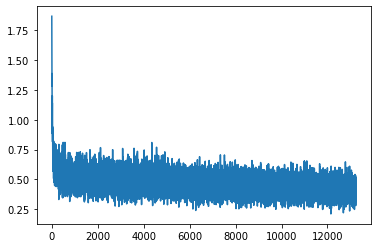

In [ ]:
import matplotlib.pyplot as plt
plt.plot(batch_losses[0:])
print(batch_losses[-1])

tensor(0.8385, device='cuda:0')


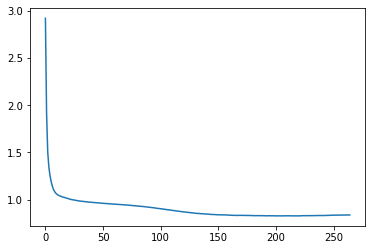

In [ ]:
plt.plot(validation_gt_distance[0:])
print(validation_gt_distance[-1])

# Show samples

In [ ]:
labels = get_labels(PATH + "/colors_data.txt")
pics_paths = [PATH + "/" + p for p in os.listdir(PATH) if p.split(".")[-1] == "png"]

picture: test_Color_frame#474(0.00982666015625,-0.0078125).png 0
picture: test_Color_frame#1429(-0.1484375,-0.529296875).png 1
picture: test_Color_frame#2473(-0.119140625,0.049041748046875).png 2


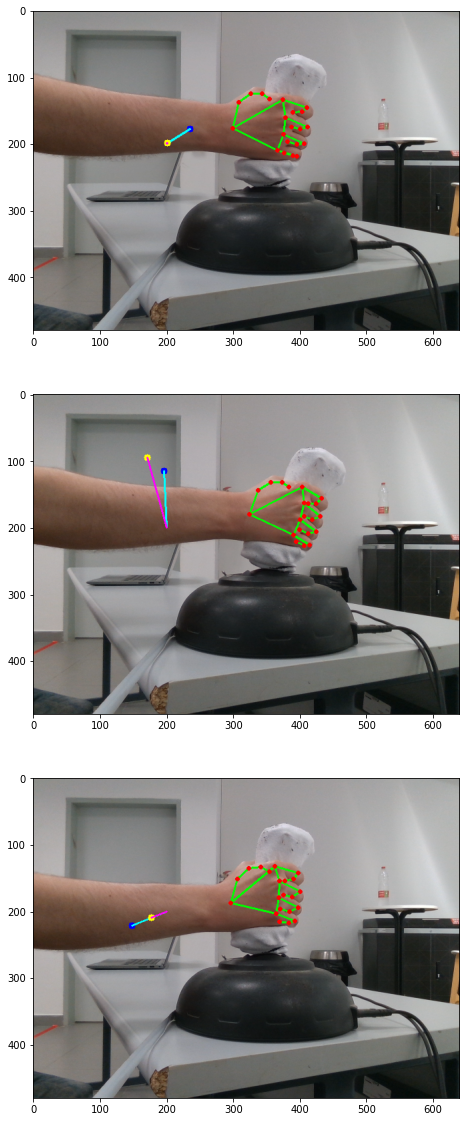

In [ ]:
import random

model.eval()

random.shuffle(pics_paths)
detector = handDetector()

fig, ax = plt.subplots(3,1,figsize=(10, 20))
with torch.no_grad():
  for i in range(3):
    img = cv2.imread(pics_paths[i]) 

    detector.find_hands(img, draw=True)
    angles = detector.find_pos(img, draw=False)

    xx, yy = labels[pics_paths[i]]
    print("picture: " + pics_paths[i].split("/")[-1] + " " + f"{i}")

    xx = int(xx*200) + 200
    yy = int(yy*200) + 200

    input = torch.tensor([angles]).type(torch.float32).to(device)
    res = model(input).to('cpu')
   
    angle= res[0][0]
    xz_angle= res[0][1]
    
    y = int(res[0][1]*200)+200
    x = int(res[0][0]*200)+200

    cv2.circle(img, (x,y), 5,(255, 0, 0), cv2.FILLED)
    cv2.line(img, (200,200),(x,y),(255,255,0),2)

    cv2.circle(img, (xx,yy), 5,(0, 255, 255), cv2.FILLED)
    cv2.line(img, (200,200),(xx,yy),(255,0,255),2)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    ax[int(i)].imshow(img);

In [ ]:
torch.save(model.average, save_path + "/checkpoint.pth")